# Kaggle GoDaddy Competition - 3rd Place Gold
I'm excited to share my 3rd place Kaggle GoDaddy competition solution. Without post process, this notebook achieves 15th place Gold. And with post process, this notebook achieves 3rd place Gold!

The solution is a simple GRU which trains and validates on 18 historical time windows using 35 months of previous microbusiness density data. The GRU receives 12 months input and predicts the next 5 months into the future. The model was tuned to optimize local CV and performs great on LB too!

# Load Train Data
In this competiton there was original data when competition began on Dec 15th. And then on Feb 20th, Kaggle published more train data. In total we have data from August 1st, 2019 thru December 31st, 2022. This is 41 months of train data for each of 3135 USA counties.

In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

VER = 98

# SET TO NONE TO TRAIN NEW MODEL
INFER_FROM_PATH = '/kaggle/input/godaddy-gru-98/'

In [2]:
# ORIGINAL TRAIN DATA
train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
print('Original train data shape:', train.shape )

# EXTRA TRAIN DATA
df = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv')
print('Extra train data shape:', df.shape )

# CONCATENATE TRAIN DATA
train = pd.concat([train,df],axis=0,ignore_index=True)
train.first_day_of_month = pd.to_datetime(train.first_day_of_month)
train = train.sort_values(['cfips','first_day_of_month'])
train['pop'] = (100 * train.active / train.microbusiness_density).round()
train['year'] = train.first_day_of_month.dt.year
print('Concatenated train data shape',train.shape)
train.head()

Original train data shape: (122265, 7)
Extra train data shape: (6270, 7)
Concatenated train data shape (128535, 9)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,pop,year
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,41527.0,2019
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,41527.0,2019
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,41527.0,2019
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,41527.0,2019
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,41527.0,2019


In [3]:
# FIRST DAY, LAST DAY
train.first_day_of_month.min(), train.first_day_of_month.max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2022-12-01 00:00:00'))

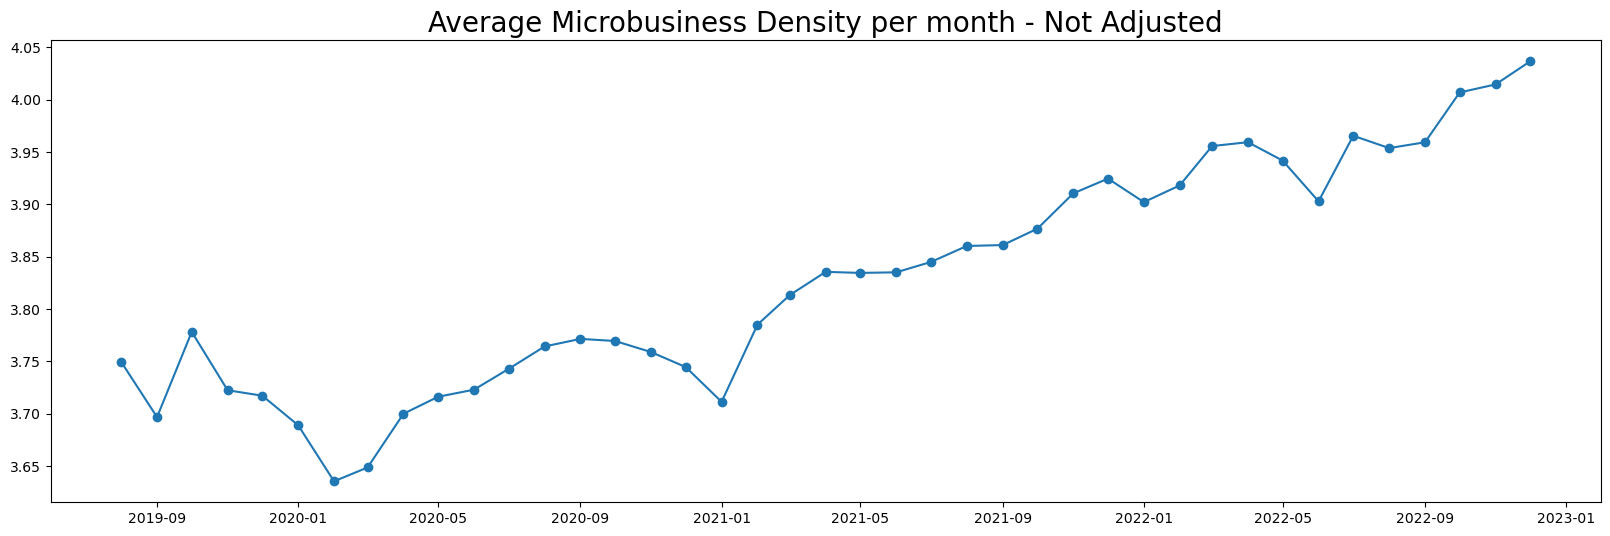

In [4]:
# PLOT AVERAGE MD PER MONTH
tmp = train.groupby('first_day_of_month').microbusiness_density.mean()
plt.figure(figsize=(20,6))
plt.plot(tmp.index, tmp,'-o')
plt.title('Average Microbusiness Density per month - Not Adjusted',size=20)
plt.show()

# Adjust All Microbusiness Density to one census
Microbusiness density is defined as microbusinesses per 100 people over the age 18. Therefore microbusiness density changes if the county population changes. To train our model, we will convert each month's microbusiness density to use the same most recent census information.

In [5]:
adults = {}
COLS = ['GEO_ID','NAME','S0101_C01_026E']

for k in [2017,2018,2019,2020,2021]:
    df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
    df2021 = df2021.iloc[1:]
    df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
    df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
    adults[k] = df2021.set_index('cfips').S0101_C01_026E.to_dict()
    
train['adult2021'] = train.cfips.map(adults[2021])
for k in [2019,2020,2021,2022]:
    train['adults'] = train.cfips.map(adults[k-2])
    train.loc[train.year==k,'microbusiness_density'] *=\
         train.adults / train.adult2021

/tmp/ipykernel_22/1436298718.py:5: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
/tmp/ipykernel_22/1436298718.py:5: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
/tmp/ipykernel_22/1436298718.py:5: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
/tmp/ipykernel_22/1436298718.py:5: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
/tmp/ipykernel_22/1436298718.py:5: D

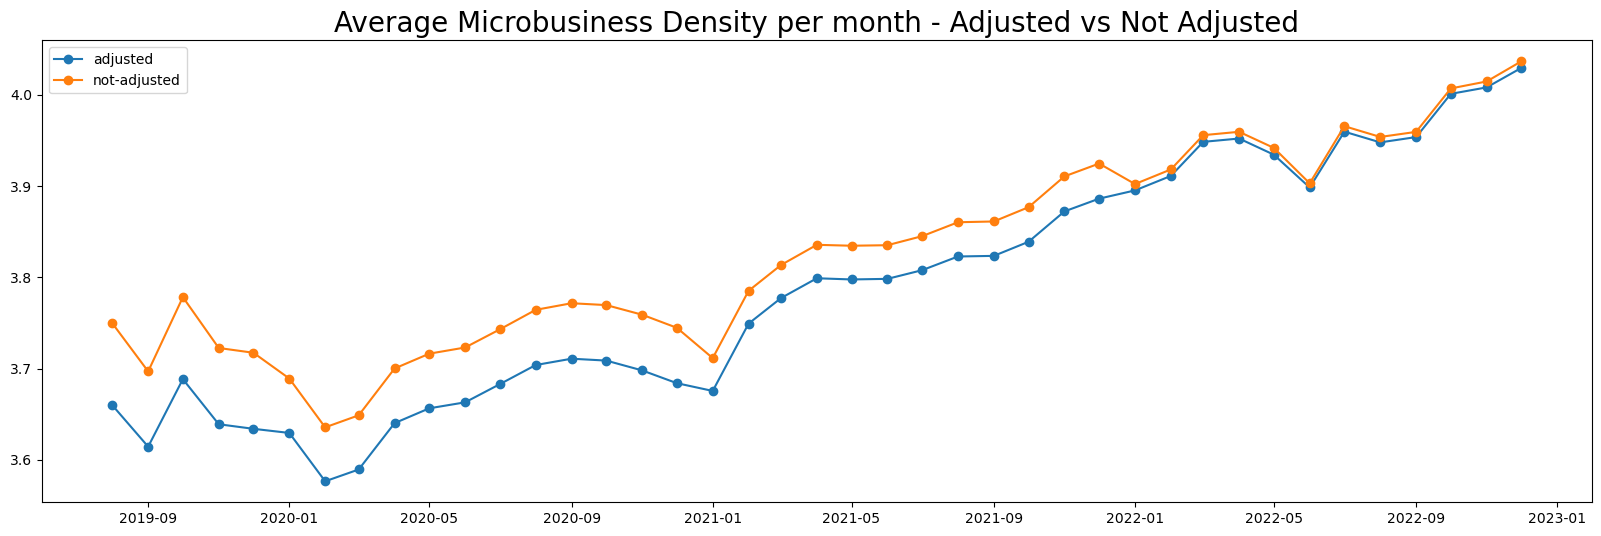

In [6]:
# PLOT AVERAGE MD PER MONTH
tmp2 = train.groupby('first_day_of_month').microbusiness_density.mean()
plt.figure(figsize=(20,6))
plt.plot(tmp2.index, tmp2,'-o', label='adjusted')
plt.plot(tmp.index, tmp,'-o', label='not-adjusted')
plt.title('Average Microbusiness Density per month - Adjusted vs Not Adjusted',size=20)
plt.legend()
plt.show()

# Find Large County Populations
We will train our model on large county populations only. We will use the top 90% quantile and ignore the bottom 10% during training. (For inference we will use last value baseline for bottom 10%). We will also remove outliers where microbusiness density exceeds 50%.

In [7]:
QUANT = 0.1
THRESH = 50

train['pop'] = (100 * train.active / train.microbusiness_density).round()
train['m'] = train.groupby('cfips').microbusiness_density.transform('max')

c = train.adult2021.quantile(q=QUANT)
KEEP = train.loc[(train.adult2021>=c)&(train.m<THRESH),'cfips'].unique()
print('We will train with', len(KEEP),'large counties')

We will train with 2814 large counties


In [8]:
SMALL = train.cfips.nunique() - len(KEEP)
print('There are ',SMALL,'small counties')

There are  321 small counties


# Prepare Train Data
Each county has 41 months of history data from August 2019 thru Dec 2022. We will train our models with Feb 2020 thru Dec 2022 only. This is 35 months. For each county, we will break this 1 time series of 35 months into 18 time series of 18 months.

For example, the first time series window will be Feb 2020 thru and including July 2021. This is 18 months. The model will train on the first 13 months of this sample and predict the last 5 months. The last time series window will be July 2021 thru and including Dec 2022. This is 18 months. The model will train on the first 13 months of this sample and predict the last 5 months.

# Small County Data
We will save small county data in a variables named `x_data2` and `y_data2`. During inference, we will just use last value baseline to predict small counties

In [9]:
TOTAL_MONTHS = 41
WIDTH = 35

data2 = train.loc[~train.cfips.isin(KEEP)]\
    .microbusiness_density.values.reshape((SMALL, TOTAL_MONTHS))[:,-1*WIDTH:]
print('Small county data has shape',data2.shape)

Small county data has shape (321, 35)


In [10]:
COPIES = 18

y_data2 = np.zeros((321*COPIES,3))
x_data2 = np.zeros((321*COPIES,1))
for j in range(321):
    for k in range(COPIES):
        i = j*COPIES + k
        x_data2[i,] = data2[j,k+(WIDTH-COPIES-5)] # LAST MONTH OF 13 MONTH TRAIN
        y_data2[i,] = data2[j,k+(WIDTH-COPIES-2):k+(WIDTH-COPIES+1)] # LAST 3 MONTHS OF 5 MONTH PREDICT
x_data2.shape, y_data2.shape

((5778, 1), (5778, 3))

# Large County Data
We will store large county data in NumPy variables `x_data` and `y_data`. And eventually put it into Pandas dataframe `train_data`.

In [11]:
data = train.loc[train.cfips.isin(KEEP)]\
    .microbusiness_density.values.reshape((len(KEEP), TOTAL_MONTHS))[:,-1*WIDTH:]
print('Large county data has shape',data.shape)

Large county data has shape (2814, 35)


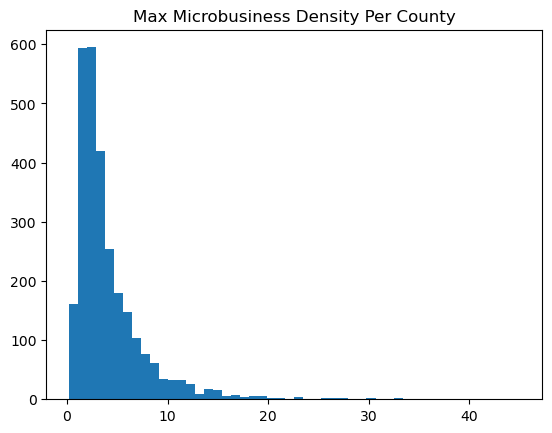

In [12]:
plt.hist( np.max(data,axis=1),bins=50 )
plt.title('Max Microbusiness Density Per County')
plt.show()

In [13]:
x_data = np.zeros((len(KEEP)*COPIES, WIDTH-COPIES-4)) # X_TRAIN TIME SERIES ARE 13 MONTHS
y_data = np.zeros((len(KEEP)*COPIES, 5)) # Y_TRAIN TIME SERIES ARE 5 MONTHS
x_data.shape, y_data.shape

((50652, 13), (50652, 5))

In [14]:
for j in range(len(KEEP)):
    for k in range(COPIES):
        i = j*COPIES + k
        x_data[i,] = data[j,k:k+(WIDTH-COPIES-4)]
        y_data[i,] = data[j,k+(WIDTH-COPIES-4):k+(WIDTH-COPIES+1)]

In [15]:
x_data.shape, y_data.shape

((50652, 13), (50652, 5))

# Convert Train Data to ratios
We will now convert the raw microbusiness density values in train data to ratio values. We will replace each month's microbusiness density by the ratio of current month divided by past month. Our model will train with and learn to predict this ratio for each month (instead of predicting the raw microbusiness density values).

After converting our train data, our `X_train` will now be time series of length 12 instead of 13. (And `y_train` will remain timeseries of length 5).

In [16]:
x_data3 = x_data.copy()
y_data3 = y_data.copy()

In [17]:
# CONVERT TO RATIOS
for k in range(WIDTH-COPIES-5):
    x_data3[:,k+1] = x_data[:,k+1] / x_data[:,k]

In [18]:
# CONVERT TO RATIOS
y_data3[:,0] = y_data[:,0] / x_data[:,-1]
for k in range(4):
    y_data3[:,k+1] = y_data[:,k+1] / y_data[:,k]

In [19]:
x_data3 = x_data3[:,1:]

In [20]:
# STANDARIZE
mn = np.mean(x_data3)
sd = np.std(x_data3)
x_data3 = (x_data3 - mn)/sd
y_data3 = (y_data3 - mn)/sd
print('Average ratio =',mn,'and Average std =', sd)

Average ratio = 1.002049802661262 and Average std = 0.049110348928488375


# Finalize Train Data and Display
We will put the NumPy arrays into a Pandas dataframe. And we will display some train samples.

In [21]:
FEATURES = [f'f{x}' for x in range(WIDTH-COPIES-4-1)]
TARGETS = [f'y{x}' for x in range(5)]
train_data = pd.DataFrame(x_data3,columns=FEATURES)
train_data[TARGETS] = y_data3
train_data['cfips'] = np.repeat(KEEP,COPIES)
print('Our GRU training data has shape:', train_data.shape )
train_data.head()

Our GRU training data has shape: (50652, 18)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,y0,y1,y2,y3,y4,cfips
0,0.125577,0.422927,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,1001
1,0.422927,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,1001
2,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,1001
3,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,1001
4,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,-0.056810,1001


In [22]:
FEATURES, TARGETS

(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'],
 ['y0', 'y1', 'y2', 'y3', 'y4'])

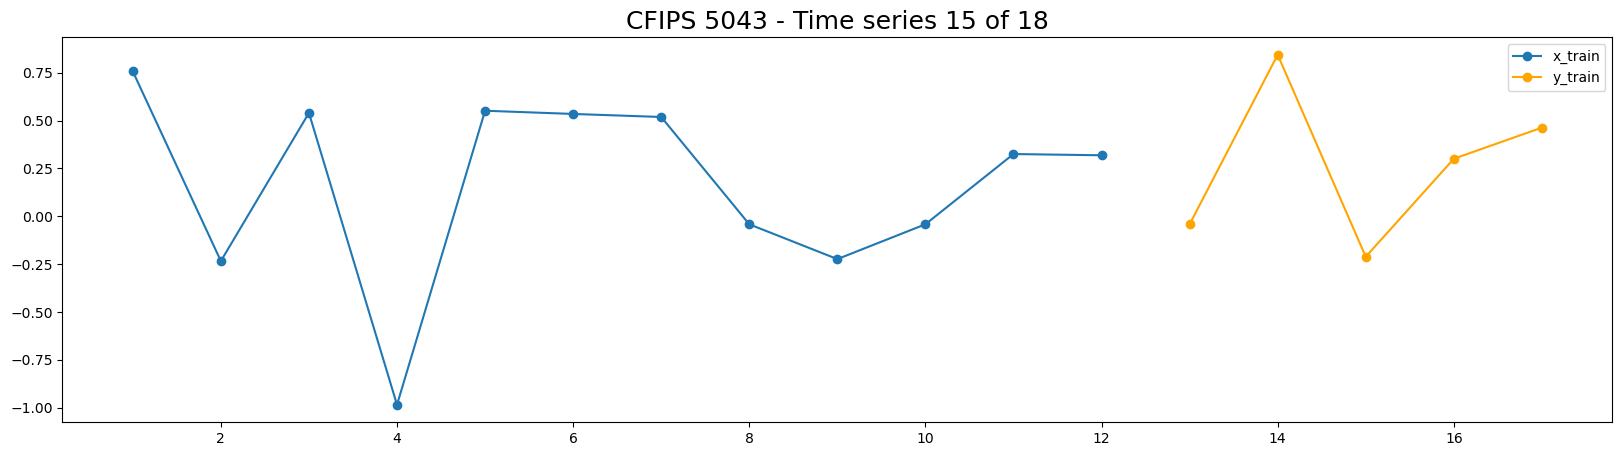

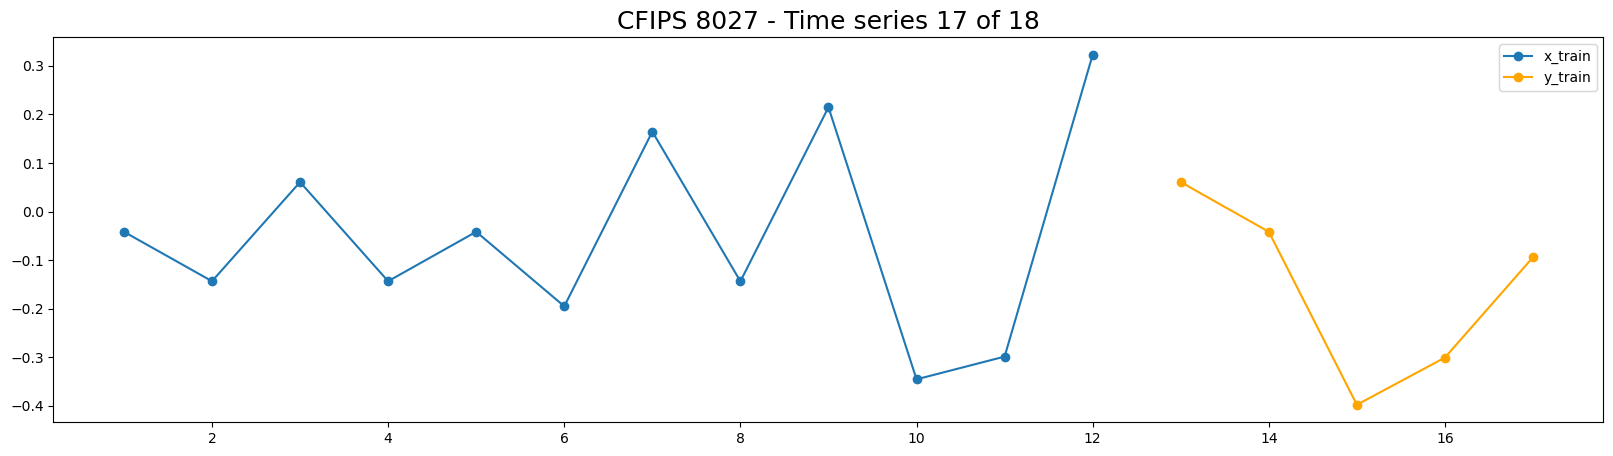

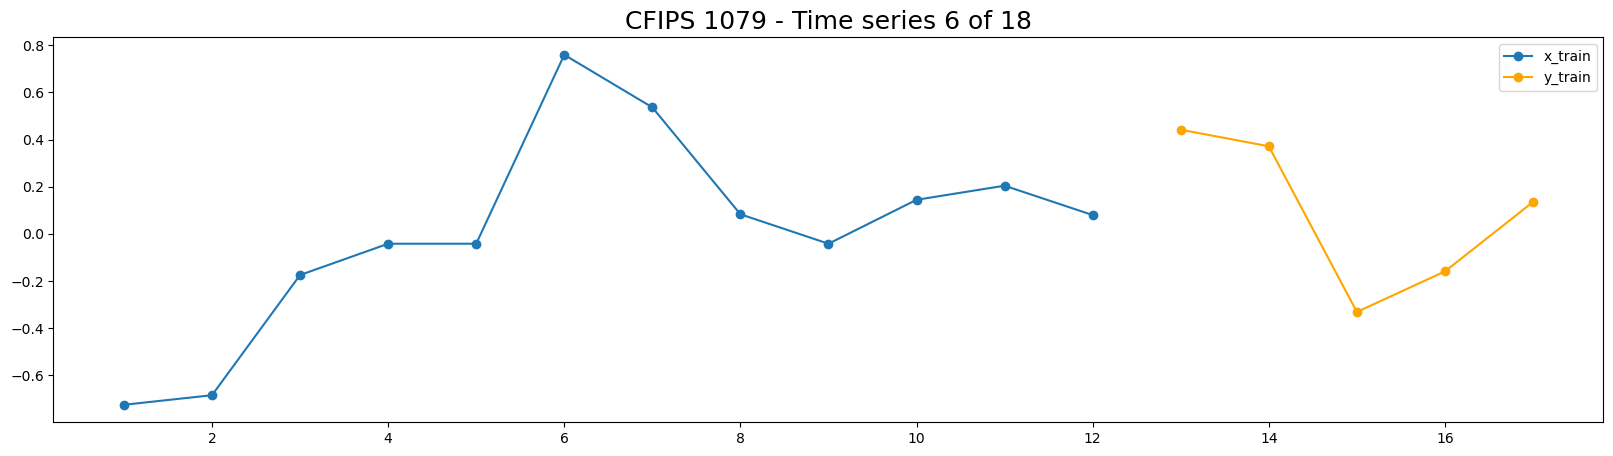

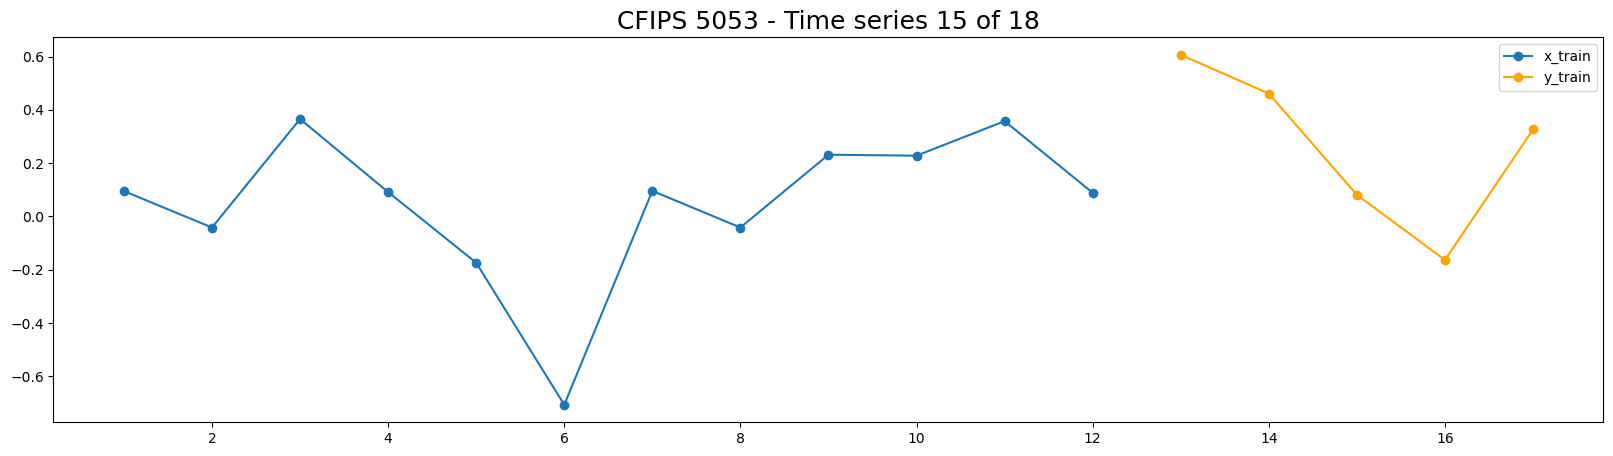

In [23]:
for k in range(4):
    j = np.random.choice(np.arange(len(x_data2)))
    
    row = j//COPIES
    col = j%COPIES
    
    plt.figure(figsize=(20,5))
    x = np.arange(WIDTH-COPIES-4-1)+1
    plt.plot(x,x_data3[j,],'-o',label='x_train')
    plt.plot([WIDTH-COPIES-4,WIDTH-COPIES-3,WIDTH-COPIES-2,WIDTH-COPIES-1,WIDTH-COPIES],y_data3[j,],
             '-o',color='orange',label='y_train')   
    plt.title(f'CFIPS {KEEP[row]} - Time series {col} of {COPIES}',size=18)
    plt.legend()
    plt.show()

# Build TensorFlow GRU Model
We will build a 3 layer GRU. It takes input of time series length 12 and outputs time series length 5

In [24]:
import tensorflow as tf
from sklearn.model_selection import GroupKFold
print('Tensorflow version',tf.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Tensorflow version 2.12.0


In [25]:
def build_model():
    
    inp = tf.keras.Input(shape=(WIDTH-COPIES-4-1,1)) # INPUT SHAPE IS 12
    
    x = tf.keras.layers.GRU(units=8, return_sequences=True)(inp)
    x = tf.keras.layers.GRU(units=8, return_sequences=True)(x)
    x = tf.keras.layers.GRU(units=8, return_sequences=False)(x)
    x = tf.keras.layers.Dense(5,activation='linear')(x) # OUTPUT SHAPE IS 5
    model = tf.keras.Model(inputs=inp, outputs=x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer = opt)
    
    return model

In [26]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 gru (GRU)                   (None, 12, 8)             264       
                                                                 
 gru_1 (GRU)                 (None, 12, 8)             432       
                                                                 
 gru_2 (GRU)                 (None, 8)                 432       
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 1,173
Trainable params: 1,173
Non-trainable params: 0
_________________________________________________________________


# Train GRU
We will train 20 folds for 2 epochs each. Each train sample has `X_train` time series of length 12. We will add 2x weight to the last 5 months because recent data is more predictive.

In [27]:
%%time

FOLDS = 20
VERBOSE = 2
oof = np.zeros((len(train_data),5))
!mkdir models

skf = GroupKFold(n_splits=FOLDS)
skf = skf.split(train_data, train_data['y0'], train_data['cfips'])
for fold,(train_idx, valid_idx) in enumerate(skf):
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)
    
    # TRAIN, VALID, HOLDOUT FOR FOLD K
    X_train = train_data.loc[train_idx, FEATURES]
    y_train = train_data.loc[train_idx, TARGETS]
    X_valid = train_data.loc[valid_idx, FEATURES]
    y_valid = train_data.loc[valid_idx, TARGETS]
    
    # WEIGHT RECENT SAMPLE MORE
    GRP = len(train_idx)//COPIES
    w = np.array( [1] * (COPIES-7) + [1,1,2,2] + [2,2,2] )
    w = w/np.sum(w)
    
    model = build_model()
    if INFER_FROM_PATH is None:
        h = model.fit(X_train,y_train, 
                      validation_data = (X_valid,y_valid),
                      sample_weight = np.tile(w,GRP),
                      batch_size=4, epochs=2, verbose=VERBOSE)
    else:
        model.load_weights(INFER_FROM_PATH + f'GRU_f{fold}_v{VER}.h5')
    model.save_weights(f'models/GRU_f{fold}_v{VER}.h5')
    
    oof[valid_idx,] = model.predict(X_valid, verbose=VERBOSE)

#########################
### Fold 1
### Train size 48114 Valid size 2538
#########################
80/80 - 4s - 4s/epoch - 46ms/step
#########################
### Fold 2
### Train size 48114 Valid size 2538
#########################
80/80 - 1s - 1s/epoch - 13ms/step
#########################
### Fold 3
### Train size 48114 Valid size 2538
#########################
80/80 - 1s - 1s/epoch - 17ms/step
#########################
### Fold 4
### Train size 48114 Valid size 2538
#########################
80/80 - 1s - 1s/epoch - 13ms/step
#########################
### Fold 5
### Train size 48114 Valid size 2538
#########################
80/80 - 1s - 1s/epoch - 14ms/step
#########################
### Fold 6
### Train size 48114 Valid size 2538
#########################
80/80 - 1s - 1s/epoch - 13ms/step
#########################
### Fold 7
### Train size 48114 Valid size 2538
#########################
80/80 - 1s - 1s/epoch - 13ms/step
#########################
### Fold 8
### Train size 48114 Vali

# Cross Validation
Our OOF are standardized ratios. They are not microbusiness density yet. First we must undo the standarization process by multiplying by standard deviation and adding mean. Afterward we have ratios. To acquire microbusiness density, we must recursively multiply the last value baseline by the predicting ratios.

In [28]:
def smape(y_true, y_pred):
    
    # CONVERT TO NUMPY
    y_true = np.array(y_true.flatten())
    y_pred = np.array(y_pred.flatten())
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [29]:
oof.shape, train_data.shape

((50652, 5), (50652, 18))

In [30]:
# UNDO STANDARDIZATION
oof2 = oof.copy()
oof2 = (oof2*sd)+mn

In [31]:
# AVERAGE PREDICTED RATIO FOR 5 FUTURE MONTHS
for k in range(5):
    print(oof2[:,k].mean(),f' is average predicted future month {k+1} divided by future month {k}')

1.0031450463482676  is average predicted future month 1 divided by future month 0
1.0027551501442655  is average predicted future month 2 divided by future month 1
1.003197986535563  is average predicted future month 3 divided by future month 2
1.003256373859608  is average predicted future month 4 divided by future month 3
1.0032098477146336  is average predicted future month 5 divided by future month 4


In [32]:
# CONVERT RATIOS INTO MICROBUSINESS DENSITY
oof5 = oof2.copy()
oof5[:,0] = x_data[:,-1] * oof5[:,0]
for k in range(4):
    oof5[:,k+1] = oof5[:,k] * oof5[:,k+1]

# Compute CV Scores

In [33]:
# CV SCORE FOR TOP 90% LARGE COUNTIES
y2 = y_data.copy()
m = smape(y2[:,-3:],oof5[:,-3:])
print('CV SMAPE of large counties =',m)

CV SMAPE of large counties = 2.7191152063901267


In [34]:
# MERGE LAST VALUE PREDICTIONS FOR SMALL COUNTIES
oof3 = np.concatenate([x_data2,x_data2,x_data2],axis=1)
y3 = np.concatenate([y2[:,-3:],y_data2],axis=0)
oof4 = np.concatenate([oof5[:,-3:],oof3],axis=0)
m = smape(y3,oof4)
print('We will predict last value for small counties')
print('CV SMAPE of all counties =',m)
print('Note: PP below improves CV by 0.05')

We will predict last value for small counties
CV SMAPE of all counties = 3.054472432545007
Note: PP below improves CV by 0.05


# Display OOF

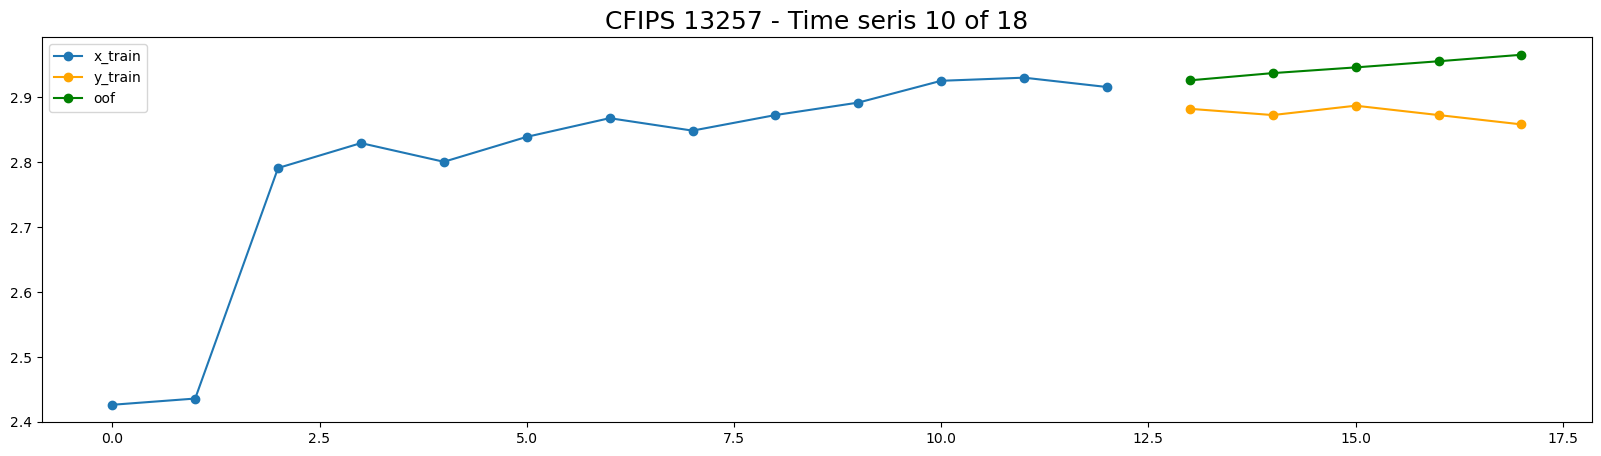

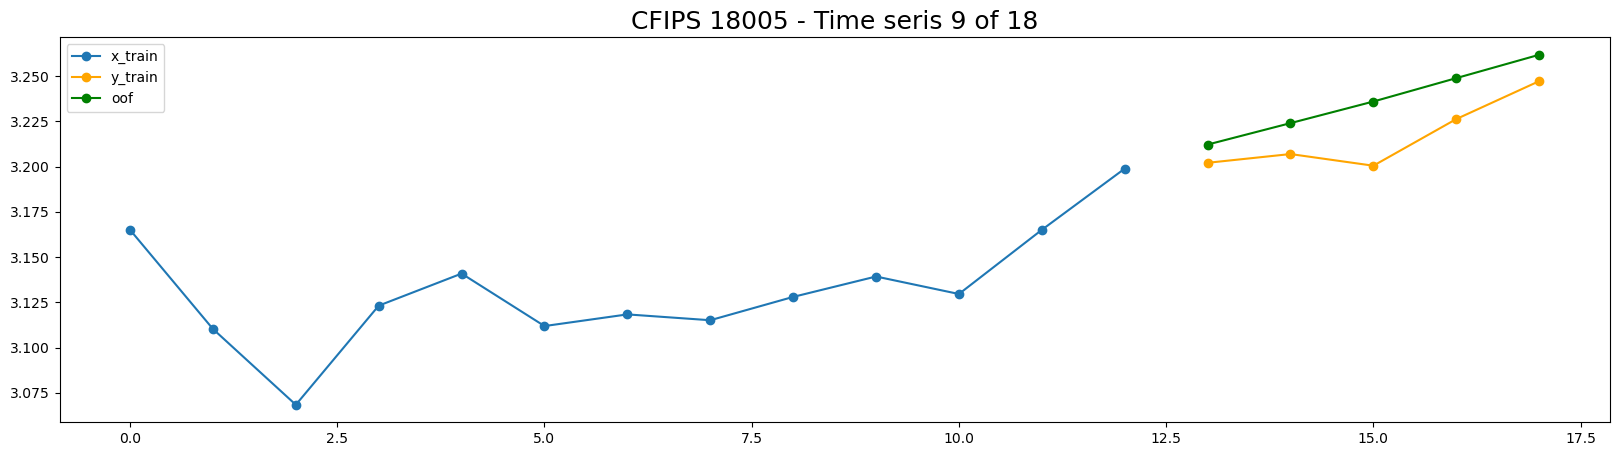

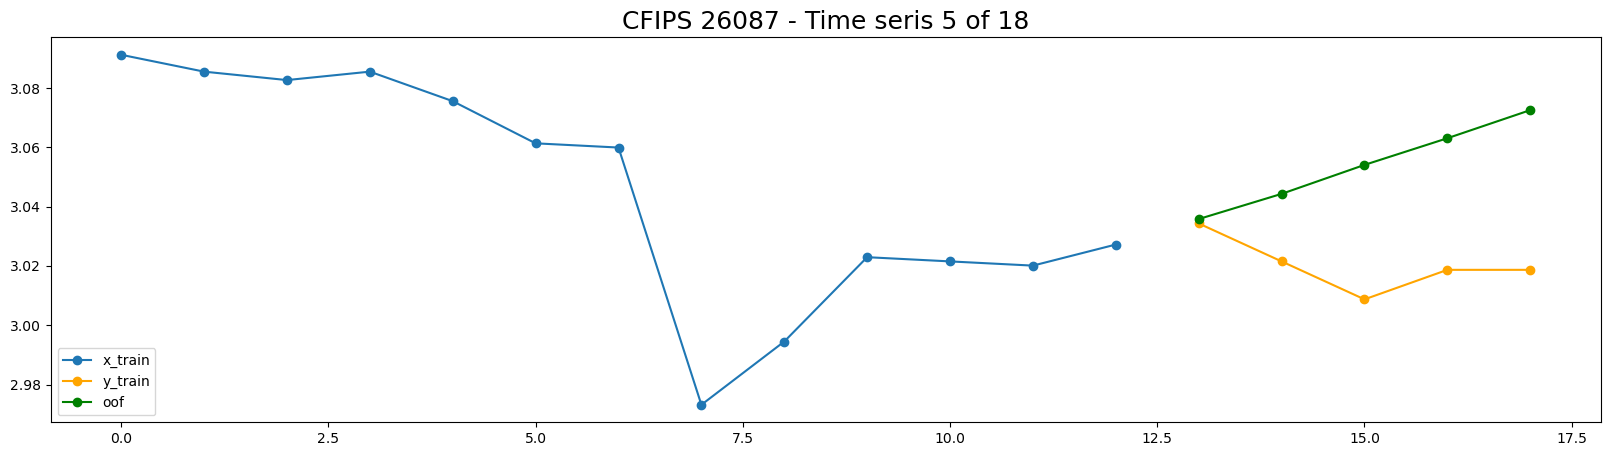

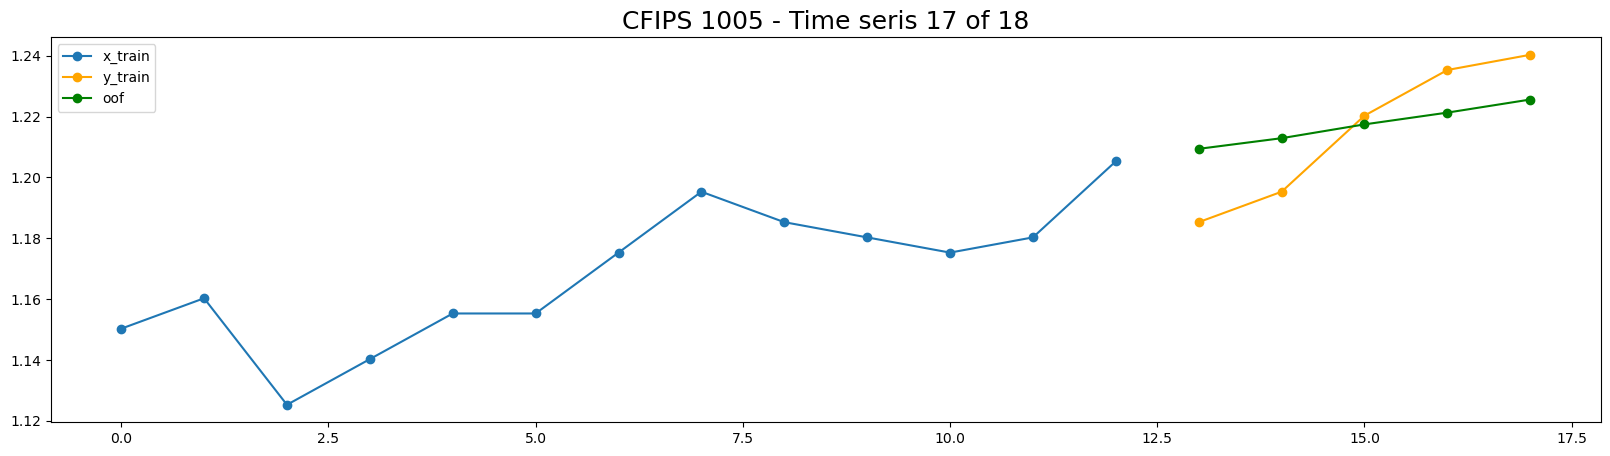

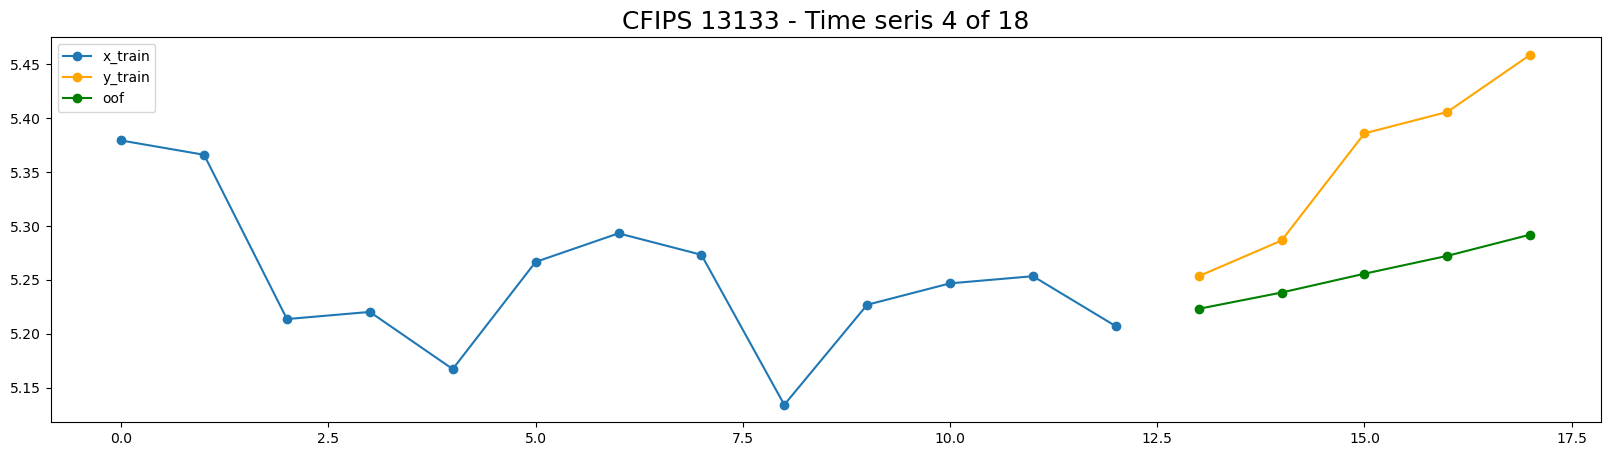

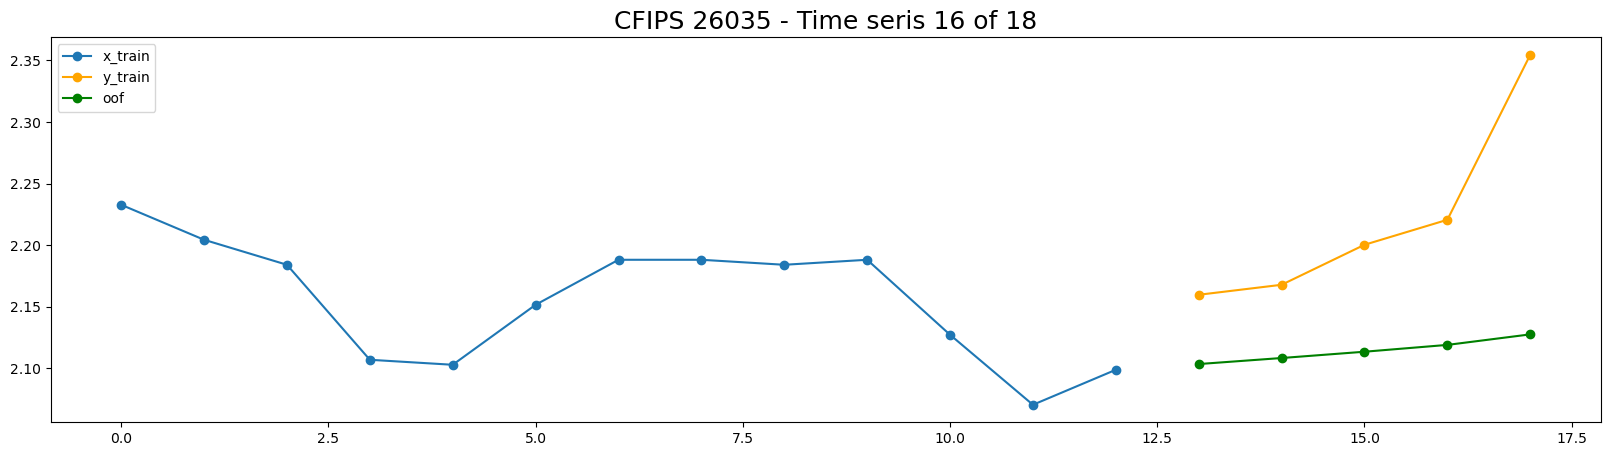

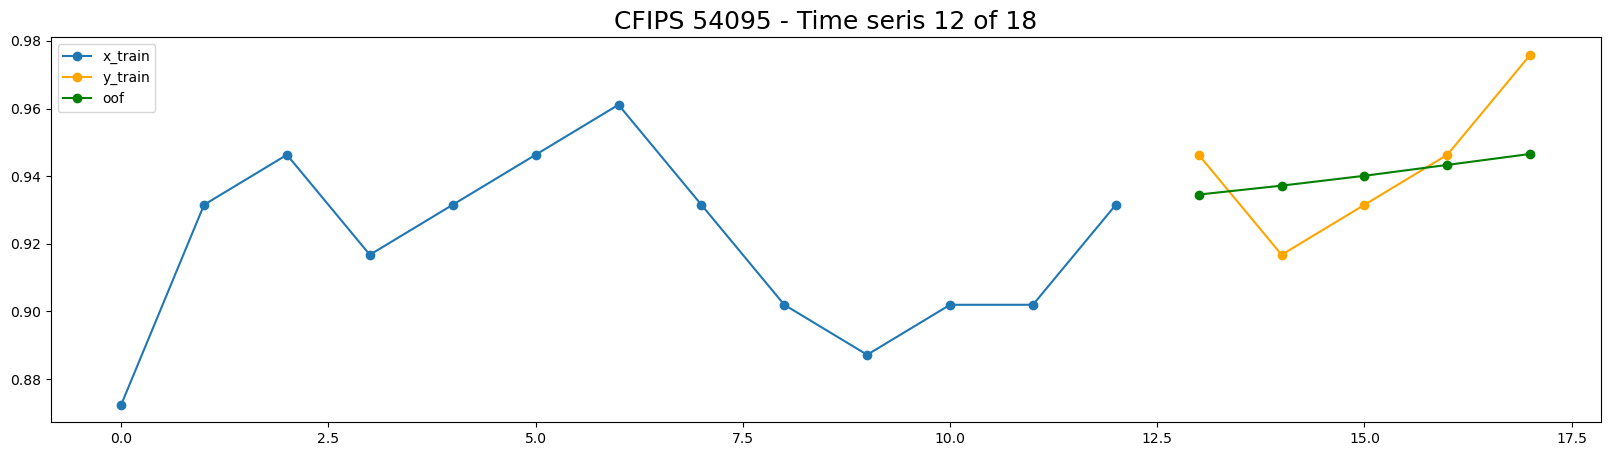

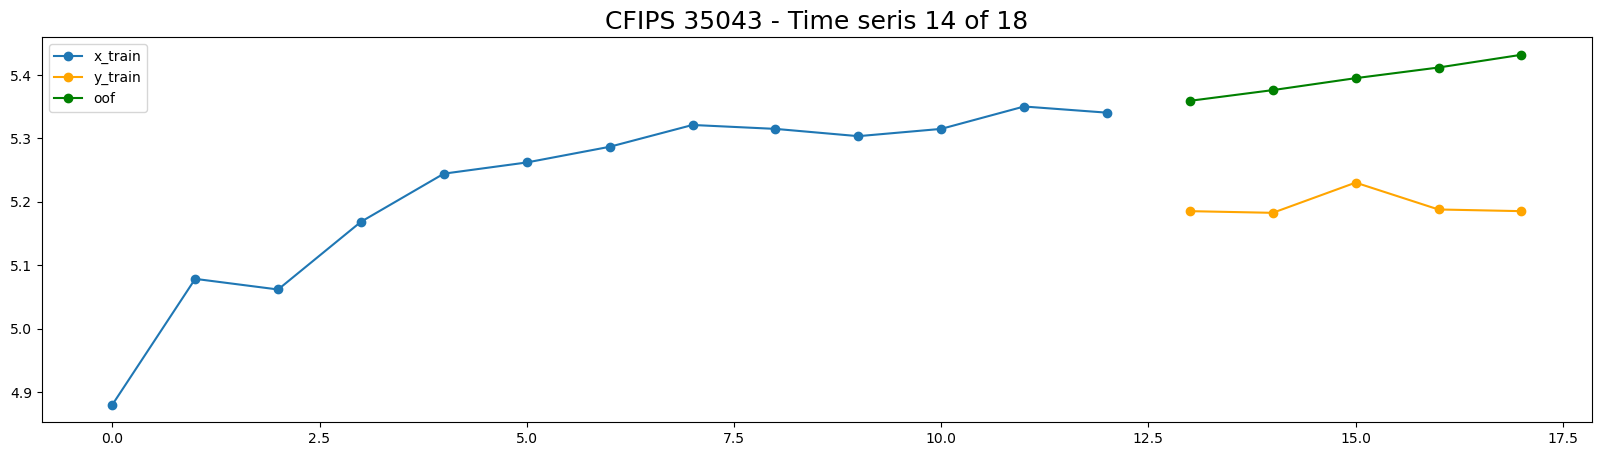

In [35]:
for k in range(8):
    j = np.random.choice(np.arange(len(x_data)))
    
    row = j//COPIES
    col = j%COPIES
    
    plt.figure(figsize=(20,5))
    x = np.arange(WIDTH-COPIES-4)
    plt.plot(x,x_data[j,],'-o',label='x_train')
    plt.plot([WIDTH-COPIES-4,WIDTH-COPIES-3,WIDTH-COPIES-2,WIDTH-COPIES-1,WIDTH-COPIES],y_data[j,],'-o',color='orange',label='y_train')
    plt.plot([WIDTH-COPIES-4,WIDTH-COPIES-3,WIDTH-COPIES-2,WIDTH-COPIES-1,WIDTH-COPIES], oof5[j,],'-o',color='green',label='oof')  
    plt.title(f'CFIPS {KEEP[row]} - Time seris {col} of {COPIES}',size=18)
    plt.legend()
    plt.show()

# Infer Test Data
To infer test, we use the last 13 months of train data. We convert the length 13 time series of raw microbusiness density into length 12 time series of ratio. Then we standardize by subtracting mean and dividing by standard deviation

In [36]:
# PREPARE TEST DATA
LL = WIDTH-COPIES-4
test0 = data[:,-1*LL:].copy()
test = data[:,-1*LL:].copy()

# CONVERT TO RATIO AND STANDARDIZE
for k in range(WIDTH-COPIES-5):
    test[:,k+1] = test0[:,k+1] / test0[:,k]
test = test[:,1:]
test = (test-mn)/sd
print('Test data shape:',test.shape)

Test data shape: (2814, 12)


In [37]:
pred = np.zeros((len(test),5))

for fold in range(FOLDS):
    print('#'*25)
    print('### Fold',fold+1)
    print('#'*25)
    
    model = build_model()
    model.load_weights(f'models/GRU_f{fold}_v{VER}.h5')

    pred += model.predict(test, verbose=VERBOSE) / FOLDS

#########################
### Fold 1
#########################
88/88 - 1s - 1s/epoch - 12ms/step
#########################
### Fold 2
#########################
88/88 - 1s - 1s/epoch - 12ms/step
#########################
### Fold 3
#########################
88/88 - 1s - 1s/epoch - 12ms/step
#########################
### Fold 4
#########################
88/88 - 1s - 1s/epoch - 12ms/step
#########################
### Fold 5
#########################
88/88 - 1s - 1s/epoch - 12ms/step
#########################
### Fold 6
#########################
88/88 - 1s - 1s/epoch - 12ms/step
#########################
### Fold 7
#########################
88/88 - 1s - 1s/epoch - 15ms/step
#########################
### Fold 8
#########################
88/88 - 1s - 1s/epoch - 13ms/step
#########################
### Fold 9
#########################
88/88 - 1s - 1s/epoch - 12ms/step
#########################
### Fold 10
#########################
88/88 - 1s - 1s/epoch - 12ms/step
#########################
###

In [38]:
# UNDO STANDARDIZATION
pred2 = pred.copy()
pred2 = (pred2*sd)+mn
print('Prediction shape',pred2.shape)

Prediction shape (2814, 5)


In [39]:
# AVERAGE PREDICTED RATIO FOR 5 FUTURE MONTHS
for k in range(5):
    print(pred2[:,k].mean(), f' is average predicted future month {k+1} divided by future month {k}')

1.0033901519122723  is average predicted future month 1 divided by future month 0
1.0030300231573945  is average predicted future month 2 divided by future month 1
1.0034688224491977  is average predicted future month 3 divided by future month 2
1.0033890125511953  is average predicted future month 4 divided by future month 3
1.0033174889511072  is average predicted future month 5 divided by future month 4


In [40]:
# CONVERT RATIOS INTO MICROBUSINESS DENSITY
pred5 = pred2.copy()
pred5[:,0] = test0[:,-1] * pred5[:,0]
for k in range(4):
    pred5[:,k+1] = pred5[:,k] * pred5[:,k+1]

# Write Submission CSV

In [41]:
# LOAD LAST VALUE BASELINE
# https://www.kaggle.com/code/cdeotte/new-last-value-baseline-1-4631
sub = pd.read_csv('/kaggle/input/new-last-value-baseline-1-4631/submission.csv')
sub['date'] = sub.row_id.apply(lambda x: x.split('_')[1])
sub['cfips'] = sub.row_id.apply(lambda x: int(x.split('_')[0]))
sub = sub.sort_values(['cfips','date'])
print( sub.shape )
sub.head()

(25080, 4)


,row_id,microbusiness_density,date,cfips
0,1001_2022-11-01,3.319231,2022-11-01,1001
3135,1001_2022-12-01,3.319231,2022-12-01,1001
6270,1001_2023-01-01,3.319231,2023-01-01,1001
9405,1001_2023-02-01,3.319231,2023-02-01,1001
12540,1001_2023-03-01,3.319231,2023-03-01,1001


In [42]:
MONS = ['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01']
for k in range(5):
    sub.loc[(sub['date']==MONS[k])&(sub.cfips.isin(KEEP)),'microbusiness_density'] = pred5[:,k]
sub = sub.reset_index(drop=True)
sub.head(16)

,row_id,microbusiness_density,date,cfips
0,1001_2022-11-01,3.319231,2022-11-01,1001
1,1001_2022-12-01,3.319231,2022-12-01,1001
2,1001_2023-01-01,3.331119,2023-01-01,1001
3,1001_2023-02-01,3.341881,2023-02-01,1001
4,1001_2023-03-01,3.354074,2023-03-01,1001
5,1001_2023-04-01,3.365742,2023-04-01,1001
6,1001_2023-05-01,3.377116,2023-05-01,1001
7,1001_2023-06-01,3.319231,2023-06-01,1001
8,1003_2022-11-01,7.935207,2022-11-01,1003
9,1003_2022-12-01,7.935207,2022-12-01,1003


In [43]:
sub = sub.sort_index()
sub = sub[['row_id','microbusiness_density']]
sub.to_csv(f'submission_gru_v{VER}.csv',index=False)

# Post Process 1 - Large Counties
There are two post process. First for **large counties** we adjust the multiplier between January 2023 predictions versus December 2022 train data. Then we adjust multipliers for small counties. All multipliers were discovered by probing the public LB (which has January 2023 data).

In [44]:
# LOAD SUBMISSION GRU
sub = pd.read_csv(f'submission_gru_v{VER}.csv')
sub = sub.sort_values('row_id').reset_index(drop=True)
sub['cfips'] = sub.row_id.apply(lambda x: int(x.split('_')[0]))
sub['date'] = sub.row_id.apply(lambda x: x.split('_')[1])
sub.head()

,row_id,microbusiness_density,cfips,date
0,10001_2022-11-01,7.064056,10001,2022-11-01
1,10001_2022-12-01,7.064056,10001,2022-12-01
2,10001_2023-01-01,7.094459,10001,2023-01-01
3,10001_2023-02-01,7.123335,10001,2023-02-01
4,10001_2023-03-01,7.155556,10001,2023-03-01


In [45]:
tmp = train.groupby('cfips').active.agg('last')
ADJUST2 = tmp.loc[tmp>=150].index.values
print('We will adjust',len( ADJUST2 ),'large counties')

We will adjust 2362 large counties


In [46]:
# LOAD LAST VALUE BASELINE
# https://www.kaggle.com/code/cdeotte/new-last-value-baseline-1-4631
sub2 = pd.read_csv('/kaggle/input/new-last-value-baseline-1-4631/submission.csv')
sub2['date'] = sub2.row_id.apply(lambda x: x.split('_')[1])
sub2['cfips'] = sub2.row_id.apply(lambda x: int(x.split('_')[0]))
sub2 = sub2.sort_values(['cfips','date'])
#print( sub2.shape )
#sub2.head()

In [47]:
m1 = sub2.loc[(sub2.cfips.isin(ADJUST2))&(sub2['date']=='2023-01-01'),'microbusiness_density'].mean()
m2 = sub.loc[(sub.cfips.isin(ADJUST2))&(sub['date']=='2023-01-01'),'microbusiness_density'].mean()
print(m2/m1,'is ratio of January 2023 divided by December 2022')

OPTIMAL = 1.0045
RR = OPTIMAL / (m2/m1)
print('Optimal from LB probe is',OPTIMAL,', we need',RR,'more')

1.0032088386719011 is ratio of January 2023 divided by December 2022
Optimal from LB probe is 1.0045 , we need 1.0012870314518043 more


In [48]:
# ADJUST LARGE COUNTY with MULTIPLIER
sub.loc[sub.cfips.isin(ADJUST2),'microbusiness_density'] =\
    sub.loc[sub.cfips.isin(ADJUST2),'microbusiness_density'] * RR

# Post Process 2 - Small Counties
The multipliers for **small counties** is different than large counties. Below we adjust the multipliers for small counties. These multipliers were discovered by probing the public LB (which contains January 2023 data).

In [49]:
COUNTIES = [21201, 31171, 20071, 48311, 46031, 13307, 46007, 46089, 13239, 46017, 31015, 30069, 31057,
48345, 20033, 31103, 30033, 48205, 20135, 21189, 13061, 38095, 20195, 5013, 55078, 37177,
22023, 48447, 20203, 38065, 21105, 48079, 16025, 46049]

MULTIPLIERS = [5/10, 8/9, 9/10, 11/12, 12/13, 12/13, 14/15, 14/15, 13/15, 11/10, 12/11, 12/11, 17/16,
18/19, 18/19, 19/20, 19/20, 14/21, 19/18, 18/17, 21/20, 17/16, 18/17, 16/15, 20/21, 26/27,
26/27, 21/22, 27/28, 24/22, 27/25, 30/29, 30/29, 29/28]

In [50]:
# ADJUST SMALL COUNTY with MULTIPLIER
for c,m in zip(COUNTIES, MULTIPLIERS):
    sub.loc[sub.cfips==c,'microbusiness_density'] *= m

In [51]:
sub = sub.drop(['cfips','date'],axis=1)
sub.to_csv(f'submission_gru_v{VER}_PP.csv',index=False)
sub.head()

,row_id,microbusiness_density
0,10001_2022-11-01,7.073147
1,10001_2022-12-01,7.073147
2,10001_2023-01-01,7.103590
3,10001_2023-02-01,7.132502
4,10001_2023-03-01,7.164765
